In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import random
from tqdm import tqdm
import os

# Отключаем многопроцессность для избежания проблем с pickle
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["OMP_NUM_THREADS"] = "1"
torch.set_num_threads(1)

In [15]:
class BaseTransform:
    def __init__(self, p: float = 1.0):
        if not (0.0 <= p <= 1.0):
            raise ValueError("p must be in [0, 1]")
        self.p = p

    def apply(self, img: Image.Image) -> Image.Image:
        raise NotImplementedError

    def __call__(self, img: Image.Image) -> Image.Image:
        if random.random() < self.p:
            return self.apply(img)
        return img


class RandomCrop(BaseTransform):
    def __init__(self, p: float = 1.0, size=None, padding=0):
        super().__init__(p)
        self.size = size
        self.padding = padding

    def apply(self, img: Image.Image) -> Image.Image:
        # Ручной паддинг без torchvision
        if self.padding > 0:
            w, h = img.size
            new_img = Image.new("RGB", (w + 2*self.padding, h + 2*self.padding), (128, 128, 128))
            new_img.paste(img, (self.padding, self.padding))
            img = new_img
        
        w, h = img.size
        if self.size is None:
            new_h, new_w = max(1, h // 2), max(1, w // 2)
        else:
            if isinstance(self.size, int):
                new_h = new_w = self.size
            else:
                new_h, new_w = self.size

        if new_h > h or new_w > w:
            return img

        top = random.randint(0, h - new_h)
        left = random.randint(0, w - new_w)
        return img.crop((left, top, left + new_w, top + new_h))


class RandomRotate(BaseTransform):
    def __init__(self, p: float = 1.0, degrees=15):
        super().__init__(p)
        if isinstance(degrees, (tuple, list)):
            if len(degrees) != 2:
                raise ValueError("degrees must be int or (min, max)")
            self.min_deg, self.max_deg = degrees
        else:
            self.min_deg, self.max_deg = -abs(degrees), abs(degrees)

    def apply(self, img: Image.Image) -> Image.Image:
        angle = random.uniform(self.min_deg, self.max_deg)
        return img.rotate(angle, resample=Image.BICUBIC, expand=False)


class RandomZoom(BaseTransform):
    def __init__(self, p: float = 1.0, zoom_range=(0.9, 1.1)):
        super().__init__(p)
        if isinstance(zoom_range, (tuple, list)) and len(zoom_range) == 2:
            self.min_zoom, self.max_zoom = sorted(zoom_range)
        else:
            raise ValueError("zoom_range must be (min, max)")

    def apply(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        zoom = random.uniform(self.min_zoom, self.max_zoom)
        new_w, new_h = int(w * zoom), int(h * zoom)

        if new_w == 0 or new_h == 0:
            return img

        resized = img.resize((new_w, new_h), Image.BICUBIC)

        if zoom >= 1.0:
            left = (new_w - w) // 2
            top = (new_h - h) // 2
            return resized.crop((left, top, left + w, top + h))
        else:
            new_img = Image.new("RGB", (w, h), (128, 128, 128))
            paste_x = (w - new_w) // 2
            paste_y = (h - new_h) // 2
            new_img.paste(resized, (paste_x, paste_y))
            return new_img


class ToTensor:
    def __call__(self, img: Image.Image) -> torch.Tensor:
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img_np = np.array(img).astype(np.float32) / 255.0
        return torch.from_numpy(img_np).permute(2, 0, 1)


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img: Image.Image):
        for t in self.transforms:
            img = t(img)
        return img


In [16]:
def get_dataloaders(augmentations=None, batch_size=64):
    """
    Возвращает DataLoader'ы для CIFAR-10 с заданными аугментациями.
    """
    # Трансформации для трейна
    train_transforms = []
    if augmentations:
        train_transforms.extend(augmentations)
    train_transforms.append(ToTensor())
    train_transform = Compose(train_transforms)
    
    # Трансформации для теста (только ToTensor)
    test_transform = Compose([ToTensor()])

    # Загрузка датасета (без лямбд!)
    train_dataset = datasets.CIFAR10(
        root='./data', train=True, download=True, 
        transform=train_transform
    )
    
    test_dataset = datasets.CIFAR10(
        root='./data', train=False, download=True,
        transform=test_transform
    )

    # DataLoader'ы с num_workers=0 для избежания проблем с pickle
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,  # Ключевое исправление!
        pin_memory=False
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,  # Ключевое исправление!
        pin_memory=False
    )
    
    return train_loader, test_loader

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [18]:
def train_model(model, train_loader, test_loader, epochs=15, lr=0.001, device='cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    
    for epoch in range(epochs):
        # Обучение
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        scheduler.step()
        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Валидация
        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        test_loss = test_loss / total
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f} | "
              f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    return {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'train_acc': train_accs,
        'test_acc': test_accs
    }

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Сценарии аугментаций
scenarios = {
    "no_aug": None,
    "light_aug": [
        RandomCrop(p=0.3, size=32, padding=4),
        RandomRotate(p=0.3, degrees=10),
        RandomZoom(p=0.3, zoom_range=(0.95, 1.05))
    ],
    "heavy_aug": [
        RandomCrop(p=0.8, size=32, padding=4),
        RandomRotate(p=0.8, degrees=20),
        RandomZoom(p=0.8, zoom_range=(0.8, 1.2))
    ]
}

results = {}

for name, augmentations in scenarios.items():
    print(f"\n{'='*50}")
    print(f"Training with: {name}")
    print(f"{'='*50}")
    
    # Фиксируем seed для воспроизводимости
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)
    
    # Получаем датасеты
    train_loader, test_loader = get_dataloaders(augmentations=augmentations, batch_size=64)
    
    # Инициализируем модель
    model = SimpleCNN()
    
    # Обучаем (меньше эпох для демо)
    results[name] = train_model(
        model, 
        train_loader, 
        test_loader, 
        epochs=15, 
        lr=0.001, 
        device=device
    )

Using device: cpu

Training with: no_aug
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/15: 100%|██████████| 782/782 [01:20<00:00,  9.67it/s]


Epoch 1/15 | Train Loss: 1.7201, Acc: 0.3243 | Test Loss: 1.9817, Acc: 0.2914 | LR: 0.000989


Epoch 2/15: 100%|██████████| 782/782 [01:23<00:00,  9.39it/s]


Epoch 2/15 | Train Loss: 1.3948, Acc: 0.4793 | Test Loss: 1.2267, Acc: 0.5432 | LR: 0.000957


Epoch 3/15: 100%|██████████| 782/782 [01:12<00:00, 10.77it/s]


Epoch 3/15 | Train Loss: 1.2385, Acc: 0.5497 | Test Loss: 1.0861, Acc: 0.6046 | LR: 0.000905


Epoch 4/15: 100%|██████████| 782/782 [01:14<00:00, 10.55it/s]


Epoch 4/15 | Train Loss: 1.1307, Acc: 0.5950 | Test Loss: 1.2586, Acc: 0.5617 | LR: 0.000835


Epoch 5/15: 100%|██████████| 782/782 [01:14<00:00, 10.49it/s]


Epoch 5/15 | Train Loss: 1.0490, Acc: 0.6267 | Test Loss: 0.9773, Acc: 0.6501 | LR: 0.000750


Epoch 6/15: 100%|██████████| 782/782 [01:12<00:00, 10.74it/s]


Epoch 6/15 | Train Loss: 0.9838, Acc: 0.6534 | Test Loss: 0.9462, Acc: 0.6617 | LR: 0.000655


Epoch 7/15: 100%|██████████| 782/782 [01:08<00:00, 11.36it/s]


Epoch 7/15 | Train Loss: 0.9310, Acc: 0.6722 | Test Loss: 0.9387, Acc: 0.6578 | LR: 0.000552


Epoch 8/15: 100%|██████████| 782/782 [01:10<00:00, 11.15it/s]


Epoch 8/15 | Train Loss: 0.8829, Acc: 0.6906 | Test Loss: 0.8964, Acc: 0.6715 | LR: 0.000448


Epoch 9/15: 100%|██████████| 782/782 [01:16<00:00, 10.26it/s]


Epoch 9/15 | Train Loss: 0.8436, Acc: 0.7082 | Test Loss: 0.8243, Acc: 0.7017 | LR: 0.000345


Epoch 10/15: 100%|██████████| 782/782 [01:13<00:00, 10.62it/s]


Epoch 10/15 | Train Loss: 0.8053, Acc: 0.7163 | Test Loss: 0.7786, Acc: 0.7196 | LR: 0.000250


Epoch 11/15: 100%|██████████| 782/782 [01:09<00:00, 11.19it/s]


Epoch 11/15 | Train Loss: 0.7781, Acc: 0.7276 | Test Loss: 0.7826, Acc: 0.7189 | LR: 0.000165


Epoch 12/15: 100%|██████████| 782/782 [01:08<00:00, 11.42it/s]


Epoch 12/15 | Train Loss: 0.7523, Acc: 0.7371 | Test Loss: 0.7977, Acc: 0.7170 | LR: 0.000095


Epoch 13/15: 100%|██████████| 782/782 [01:13<00:00, 10.70it/s]


Epoch 13/15 | Train Loss: 0.7388, Acc: 0.7428 | Test Loss: 0.7406, Acc: 0.7345 | LR: 0.000043


Epoch 14/15: 100%|██████████| 782/782 [01:15<00:00, 10.34it/s]


Epoch 14/15 | Train Loss: 0.7237, Acc: 0.7488 | Test Loss: 0.7359, Acc: 0.7358 | LR: 0.000011


Epoch 15/15: 100%|██████████| 782/782 [01:08<00:00, 11.43it/s]


Epoch 15/15 | Train Loss: 0.7151, Acc: 0.7512 | Test Loss: 0.7335, Acc: 0.7357 | LR: 0.000000

Training with: light_aug
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/15: 100%|██████████| 782/782 [01:10<00:00, 11.14it/s]


Epoch 1/15 | Train Loss: 1.7669, Acc: 0.3015 | Test Loss: 1.7240, Acc: 0.3421 | LR: 0.000989


Epoch 2/15: 100%|██████████| 782/782 [01:14<00:00, 10.51it/s]


Epoch 2/15 | Train Loss: 1.4968, Acc: 0.4322 | Test Loss: 1.2736, Acc: 0.5188 | LR: 0.000957


Epoch 3/15: 100%|██████████| 782/782 [01:20<00:00,  9.71it/s]


Epoch 3/15 | Train Loss: 1.3406, Acc: 0.5061 | Test Loss: 1.2660, Acc: 0.5375 | LR: 0.000905


Epoch 4/15: 100%|██████████| 782/782 [01:14<00:00, 10.55it/s]


Epoch 4/15 | Train Loss: 1.2372, Acc: 0.5559 | Test Loss: 1.2063, Acc: 0.5569 | LR: 0.000835


Epoch 5/15: 100%|██████████| 782/782 [01:06<00:00, 11.78it/s]


Epoch 5/15 | Train Loss: 1.1578, Acc: 0.5872 | Test Loss: 1.1029, Acc: 0.6000 | LR: 0.000750


Epoch 6/15: 100%|██████████| 782/782 [01:05<00:00, 11.91it/s]


Epoch 6/15 | Train Loss: 1.0923, Acc: 0.6141 | Test Loss: 1.2134, Acc: 0.5525 | LR: 0.000655


Epoch 7/15: 100%|██████████| 782/782 [01:05<00:00, 11.96it/s]


Epoch 7/15 | Train Loss: 1.0424, Acc: 0.6355 | Test Loss: 1.0176, Acc: 0.6314 | LR: 0.000552


Epoch 8/15: 100%|██████████| 782/782 [01:06<00:00, 11.70it/s]


Epoch 8/15 | Train Loss: 0.9987, Acc: 0.6510 | Test Loss: 1.0154, Acc: 0.6324 | LR: 0.000448


Epoch 9/15: 100%|██████████| 782/782 [01:20<00:00,  9.69it/s]


Epoch 9/15 | Train Loss: 0.9647, Acc: 0.6646 | Test Loss: 0.8642, Acc: 0.6888 | LR: 0.000345


Epoch 10/15: 100%|██████████| 782/782 [01:37<00:00,  8.05it/s]


Epoch 10/15 | Train Loss: 0.9296, Acc: 0.6763 | Test Loss: 0.8610, Acc: 0.6869 | LR: 0.000250


Epoch 11/15: 100%|██████████| 782/782 [01:38<00:00,  7.95it/s]


Epoch 11/15 | Train Loss: 0.9058, Acc: 0.6845 | Test Loss: 0.8092, Acc: 0.7110 | LR: 0.000165


Epoch 12/15: 100%|██████████| 782/782 [01:18<00:00,  9.96it/s]


Epoch 12/15 | Train Loss: 0.8836, Acc: 0.6914 | Test Loss: 0.8031, Acc: 0.7168 | LR: 0.000095


Epoch 13/15: 100%|██████████| 782/782 [01:21<00:00,  9.64it/s]


Epoch 13/15 | Train Loss: 0.8763, Acc: 0.6960 | Test Loss: 0.7743, Acc: 0.7231 | LR: 0.000043


Epoch 14/15: 100%|██████████| 782/782 [01:14<00:00, 10.51it/s]


Epoch 14/15 | Train Loss: 0.8565, Acc: 0.7046 | Test Loss: 0.7675, Acc: 0.7253 | LR: 0.000011


Epoch 15/15: 100%|██████████| 782/782 [01:10<00:00, 11.07it/s]


Epoch 15/15 | Train Loss: 0.8521, Acc: 0.7027 | Test Loss: 0.7654, Acc: 0.7259 | LR: 0.000000

Training with: heavy_aug
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/15: 100%|██████████| 782/782 [01:16<00:00, 10.21it/s]


Epoch 1/15 | Train Loss: 1.8186, Acc: 0.2855 | Test Loss: 1.8295, Acc: 0.3047 | LR: 0.000989


Epoch 2/15: 100%|██████████| 782/782 [01:33<00:00,  8.33it/s]


Epoch 2/15 | Train Loss: 1.6148, Acc: 0.3819 | Test Loss: 1.3940, Acc: 0.4745 | LR: 0.000957


Epoch 3/15: 100%|██████████| 782/782 [01:27<00:00,  8.97it/s]


Epoch 3/15 | Train Loss: 1.4693, Acc: 0.4571 | Test Loss: 1.3191, Acc: 0.5156 | LR: 0.000905


Epoch 4/15: 100%|██████████| 782/782 [01:11<00:00, 10.87it/s]


Epoch 4/15 | Train Loss: 1.3760, Acc: 0.4966 | Test Loss: 1.1714, Acc: 0.5753 | LR: 0.000835


Epoch 5/15: 100%|██████████| 782/782 [01:10<00:00, 11.06it/s]


Epoch 5/15 | Train Loss: 1.2972, Acc: 0.5303 | Test Loss: 1.1180, Acc: 0.5985 | LR: 0.000750


Epoch 6/15: 100%|██████████| 782/782 [01:11<00:00, 10.90it/s]


Epoch 6/15 | Train Loss: 1.2358, Acc: 0.5579 | Test Loss: 1.1508, Acc: 0.5832 | LR: 0.000655


Epoch 7/15: 100%|██████████| 782/782 [01:12<00:00, 10.85it/s]


Epoch 7/15 | Train Loss: 1.1854, Acc: 0.5798 | Test Loss: 1.1507, Acc: 0.5835 | LR: 0.000552


Epoch 8/15: 100%|██████████| 782/782 [01:17<00:00, 10.11it/s]


Epoch 8/15 | Train Loss: 1.1385, Acc: 0.5988 | Test Loss: 0.9892, Acc: 0.6536 | LR: 0.000448


Epoch 9/15: 100%|██████████| 782/782 [01:09<00:00, 11.19it/s]


Epoch 9/15 | Train Loss: 1.1027, Acc: 0.6125 | Test Loss: 0.9155, Acc: 0.6738 | LR: 0.000345


Epoch 10/15: 100%|██████████| 782/782 [01:10<00:00, 11.17it/s]


Epoch 10/15 | Train Loss: 1.0736, Acc: 0.6236 | Test Loss: 0.9505, Acc: 0.6609 | LR: 0.000250


Epoch 11/15: 100%|██████████| 782/782 [01:10<00:00, 11.13it/s]


Epoch 11/15 | Train Loss: 1.0552, Acc: 0.6318 | Test Loss: 0.8489, Acc: 0.6934 | LR: 0.000165


Epoch 12/15: 100%|██████████| 782/782 [01:11<00:00, 10.89it/s]


Epoch 12/15 | Train Loss: 1.0331, Acc: 0.6416 | Test Loss: 0.9062, Acc: 0.6794 | LR: 0.000095


Epoch 13/15: 100%|██████████| 782/782 [01:13<00:00, 10.59it/s]


Epoch 13/15 | Train Loss: 1.0175, Acc: 0.6444 | Test Loss: 0.8561, Acc: 0.6954 | LR: 0.000043


Epoch 14/15: 100%|██████████| 782/782 [01:16<00:00, 10.27it/s]


Epoch 14/15 | Train Loss: 1.0085, Acc: 0.6493 | Test Loss: 0.8377, Acc: 0.7021 | LR: 0.000011


Epoch 15/15: 100%|██████████| 782/782 [01:13<00:00, 10.70it/s]


Epoch 15/15 | Train Loss: 1.0039, Acc: 0.6511 | Test Loss: 0.8278, Acc: 0.7069 | LR: 0.000000


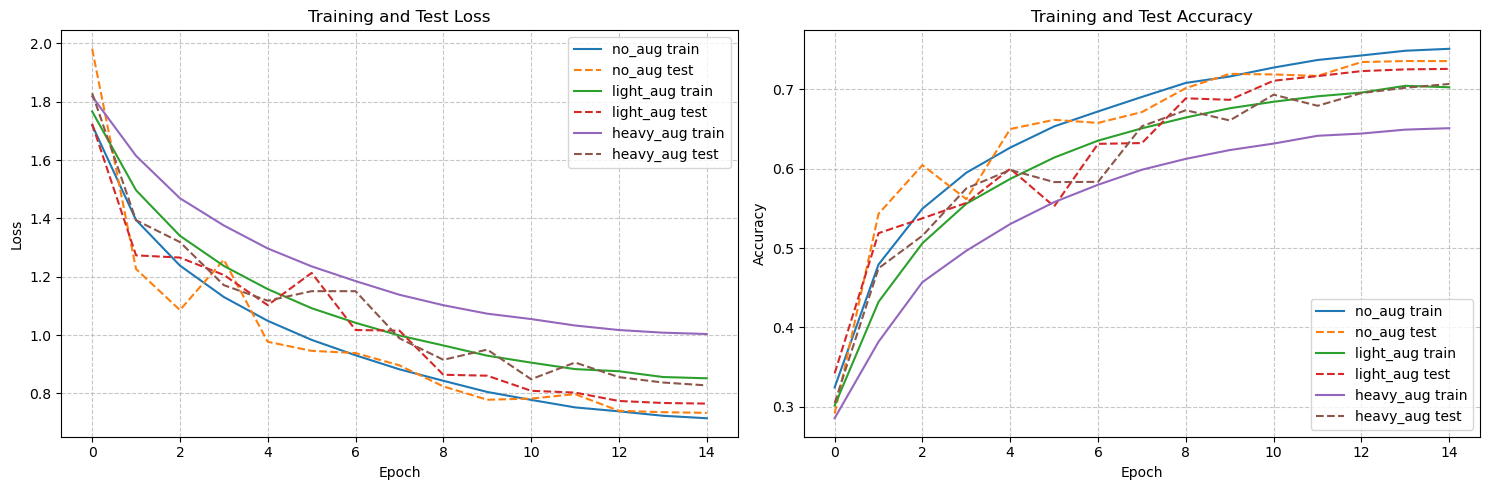

In [20]:
plt.figure(figsize=(15, 5))

# График лосса
plt.subplot(1, 2, 1)
for name, res in results.items():
    plt.plot(res['train_loss'], label=f'{name} train')
    plt.plot(res['test_loss'], '--', label=f'{name} test')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# График accuracy
plt.subplot(1, 2, 2)
for name, res in results.items():
    plt.plot(res['train_acc'], label=f'{name} train')
    plt.plot(res['test_acc'], '--', label=f'{name} test')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('augmentation_results.png', dpi=150, bbox_inches='tight')
plt.show()

Files already downloaded and verified


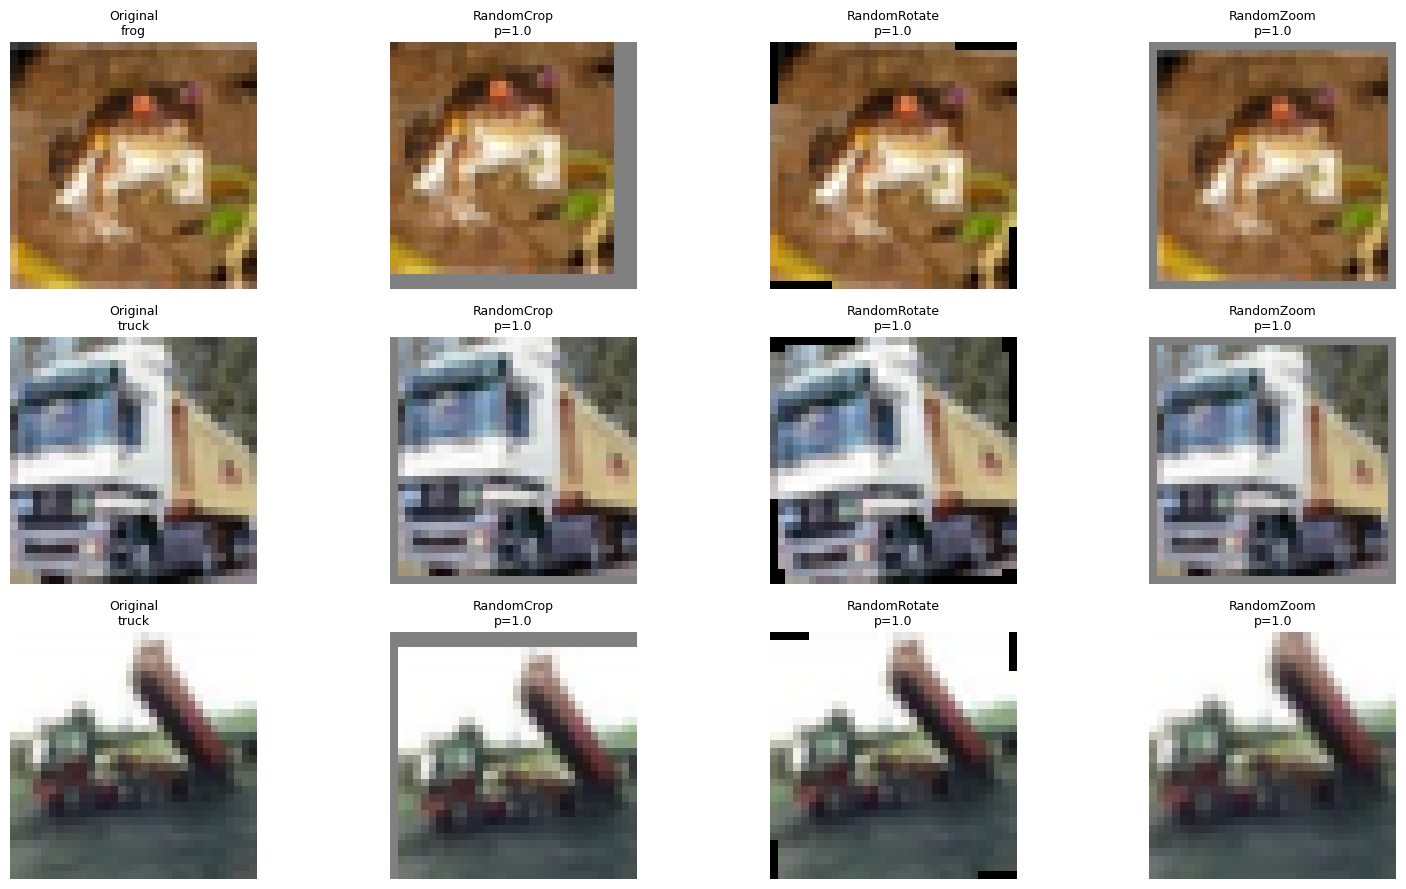

In [21]:
def visualize_augmentations(augmentations, num_samples=5):
    """Визуализирует результаты аугментаций"""
    dataset = datasets.CIFAR10(root='./data', train=True, download=True)
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    plt.figure(figsize=(16, 3 * num_samples))
    
    for i in range(num_samples):
        img, label = dataset[i]
        plt.subplot(num_samples, len(augmentations) + 1, i * (len(augmentations) + 1) + 1)
        plt.imshow(img)
        plt.title(f"Original\n{classes[label]}", fontsize=9)
        plt.axis('off')
        
        for j, aug in enumerate(augmentations):
            augmented = aug(img.copy())
            plt.subplot(num_samples, len(augmentations) + 1, i * (len(augmentations) + 1) + 2 + j)
            plt.imshow(augmented)
            plt.title(f"{aug.__class__.__name__}\np={aug.p}", fontsize=9)
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('augmentation_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

# Визуализируем аугментации
visualize_augmentations([
    RandomCrop(p=1.0, size=32, padding=4),
    RandomRotate(p=1.0, degrees=15),
    RandomZoom(p=1.0, zoom_range=(0.8, 1.2))
], num_samples=3)